
# **Linear Regression Lab Notebook**

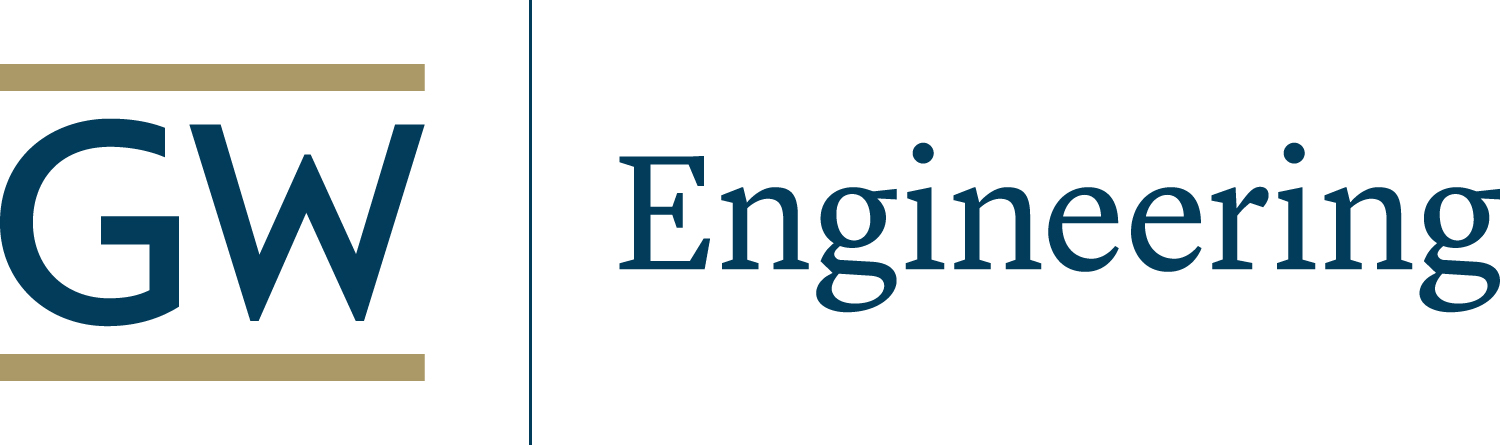

In [32]:
import warnings
warnings.filterwarnings("ignore")

Cartopy is a Python package designed to make drawing maps for data analysis and visualisation easy.


In [33]:
#Need to install this as Colab does not have it installed yet...
%pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [34]:
#Loading Libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for map projection
import cartopy.feature as cfeature # for adding features to the map
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # for splitting the dataset into training and testing sets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # for model evaluation
from sklearn.preprocessing import LabelEncoder # convert categorical variables to numerical

california_housing_data*.csv is California housing data from the 1990 US Census; more information is available at: https://developers.google.com/machine-learning/crash-course/california-housing-data-description

In [35]:
#Loading CSV into a Dataframe
df_cal = pd.read_csv('..\data\california_housing_train.csv') #relative path to the CSV file
df_cal.head() #display the first 5 rows of the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Lets use Matplotlib to explore the data.  Lat/Lon seems interesting.  Can we associate those datapoints with another features that shows a pattern?

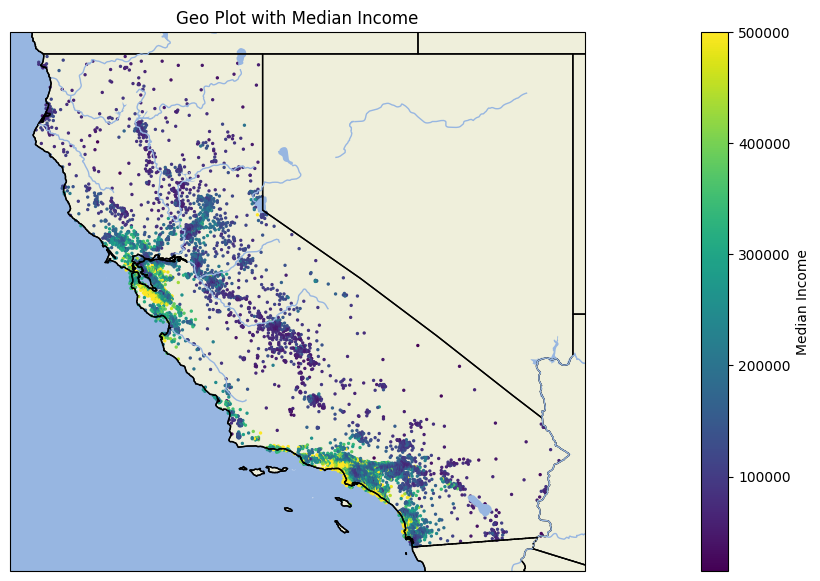

In [36]:
fig = plt.figure(figsize=(15, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle=':')

scatter = ax.scatter(df_cal['longitude'], df_cal['latitude'], s=2, transform=ccrs.PlateCarree(), c=df_cal['median_house_value'], cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)

cbar.set_label('Median Income')

plt.title('Geo Plot with Median Income')

plt.show()


Sampling in Pandas is effective when dealing with 'relatively' large datasets.

In [37]:
df_cal_sample = df_cal.sample(n=100)

In [38]:
df_cal_sample.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
6919,-118.31,34.16,37.0,2144.0,446.0,860.0,435.0,3.9464,315000.0
1758,-117.25,32.80,26.0,2442.0,659.0,1134.0,624.0,3.3274,295500.0
16809,-123.19,39.12,38.0,267.0,57.0,196.0,60.0,2.3125,70000.0
7289,-118.34,34.04,35.0,2345.0,607.0,2042.0,565.0,2.5955,139700.0
16661,-122.76,38.45,8.0,5823.0,1104.0,2864.0,1041.0,3.6292,183600.0


In [39]:
#Reset the index of the sample dataframe
df_cal_sample.reset_index(drop=True, inplace=True)
df_cal_sample.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-118.31,34.16,37.0,2144.0,446.0,860.0,435.0,3.9464,315000.0
1,-117.25,32.80,26.0,2442.0,659.0,1134.0,624.0,3.3274,295500.0
2,-123.19,39.12,38.0,267.0,57.0,196.0,60.0,2.3125,70000.0
3,-118.34,34.04,35.0,2345.0,607.0,2042.0,565.0,2.5955,139700.0
4,-122.76,38.45,8.0,5823.0,1104.0,2864.0,1041.0,3.6292,183600.0


In [40]:
fraction = 0.05

# Perform stratified sampling by grouping by 'median age'
stratified_sample = df_cal.groupby('housing_median_age', group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=1))

In [41]:
stratified_sample.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5424,-118.16,34.60,2.0,11008.0,1549.0,4098.0,1367.0,6.4865,204400.0
11640,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,137900.0
11589,-121.28,38.59,3.0,4188.0,1136.0,2081.0,995.0,3.0481,92500.0
13350,-121.93,37.70,3.0,2456.0,582.0,793.0,456.0,4.4087,225600.0
2404,-117.56,34.12,4.0,5351.0,1210.0,2988.0,1101.0,3.7973,181300.0


Binning is a data preprocessing technique used to group continuous data into discrete intervals or "bins." This process helps in simplifying and analyzing the data, especially when dealing with continuous numerical variables. Binning can be useful in various contexts, such as data visualization, reducing noise, or preparing data for certain types of machine learning models.

In [42]:
#Create bins [0,10), [10,50), (50,200)
age_bins = [0, 10, 50, 200]

In [43]:
df_cal['age_bin'] = pd.cut(df_cal['housing_median_age'], bins=age_bins, labels=['new', 'mid', 'old'])


In [44]:
df_cal.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_bin
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0,mid
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0,mid
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0,mid
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,mid
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0,mid


As we saw last week, we can use loc to filter on a value in a column.

In [45]:
df_cal.loc[df_cal['age_bin'] == 'old'].head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_bin
325,-116.88,34.08,52.0,3419.0,777.0,710.0,265.0,3.9028,128600.0,old
1011,-117.10,32.76,52.0,2606.0,426.0,883.0,380.0,4.2813,270800.0,old
1074,-117.11,32.77,52.0,1506.0,233.0,478.0,240.0,4.3875,300000.0,old
1075,-117.11,32.77,52.0,1484.0,224.0,498.0,223.0,6.6053,331400.0,old
1103,-117.11,32.67,52.0,280.0,71.0,217.0,71.0,1.4844,83300.0,old


Calculating mean without a library, why would we every do that?

Validation: You might manually calculate the mean to validate the results from a library function, ensuring that the library is working as expected.

Lightweight Code: If you want to keep your code lightweight and avoid external dependencies, manually calculating the mean can eliminate the need for importing large libraries, which might be overkill for simple tasks.

In [46]:
# Calculate the sum of the numbers
total_sum = sum(df_cal['housing_median_age'])

# Calculate the number of elements in the list
count = len(df_cal)

# Calculate the mean
mean = total_sum / count

In [47]:
mean

28.58935294117647

Lets see mode

In [48]:
from collections import Counter

In [49]:
# Count the frequency of each number
# Counter is a dictionary subclass for counting hashable objects
# It creates a dictionary where keys are the numbers and values are their counts
frequency = Counter(df_cal['housing_median_age'])

# Find the highest frequency
max_frequency = max(frequency.values())

# Find the numbers with the highest frequency
mode = [num for num, freq in frequency.items() if freq == max_frequency]

# Print the mode(s)
print("Mode:", mode)

Mode: [52.0]


In [50]:
mode

[52.0]

In [51]:
max_frequency

1052

Lastly, median is a little more involved, and a function is called for...

In [52]:
def calculate_median(numbers):
    # Sort the list of numbers
    sorted_numbers = sorted(numbers)

    # Calculate the number of data points
    n = len(sorted_numbers)

    # Find the median
    if n % 2 == 1:  # Odd number of data points
        median = sorted_numbers[n // 2]
    else:           # Even number of data points
        mid1 = sorted_numbers[n // 2 - 1] # // is integer division
        mid2 = sorted_numbers[n // 2]
        median = (mid1 + mid2) / 2

    return median

In [53]:
median = calculate_median(df_cal['housing_median_age'])

In [54]:
median

29.0

In [55]:
df_cal.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Back to the housing dataset.

In [41]:
df_cal[['households', 'population', 'median_income']].cov()

,households,population,median_income
households,147856.277053,4.013172e+05,5.608393
population,401317.218749,1.317566e+06,-1.396588
median_income,5.608393,-1.396588e+00,3.641061


In [42]:
df_cal[['households', 'population', 'median_income']].corr()

,households,population,median_income
households,1.000000,0.909247,0.007644
population,0.909247,1.000000,-0.000638
median_income,0.007644,-0.000638,1.000000


Benefits of Frequency Tables
Data Summary:

**Concise Overview**: Summarizes large datasets by showing the count or frequency of each unique value or category.
Initial Insight: Provides a quick snapshot of the distribution of values in the dataset.
Data Analysis:

**Identify Patterns**: Helps in identifying patterns, trends, and anomalies in categorical or discrete data.
Understand Distribution: Shows how data points are distributed across different categories or ranges.
Data Cleaning:

**Detect Errors**: Helps in spotting inconsistencies or data entry errors by showing unexpected frequencies or outliers.
Missing Values: Can highlight missing or unexpected values that need attention.
Visualization:

**Foundation for Graphs**: Provides the basis for creating bar charts, histograms, or pie charts, making it easier to visualize the data distribution.
Statistical Analysis:

**Mode Calculation**: Helps in identifying the most frequent category or value (the mode) in the dataset.

**Proportions and Percentages**: Allows calculation of proportions or percentages of each category relative to the total dataset.
Comparative Analysis:

**Cross-tabulations**: Useful for comparing the frequencies of two or more categorical variables in contingency tables or cross-tabulations.

In [43]:
# Create a  Series
data = df_cal['age_bin']

# Create a DataFrame for frequency and relative frequency
frequency_table = data.value_counts().reset_index()
frequency_table.columns = ['Value', 'Frequency']

# Calculate relative frequency
frequency_table['Relative Frequency'] = frequency_table['Frequency'] / frequency_table['Frequency'].sum()

print("Frequency Table with Relative Frequency:")
print(frequency_table)

Frequency Table with Relative Frequency:
  Value  Frequency  Relative Frequency
0   mid      14603            0.859000
1   new       1313            0.077235
2   old       1084            0.063765


### ***Simple Linear Regression***

There are some limitations with scikitlearn, so we will also do this with statsmodel as in the book.

In [60]:
# Linear Regression Example
'''
This demonstrates how to perform linear regression using the `scikit-learn` library.
'''

# Generate a sample dataset
np.random.seed(0)
X = 2 * np.random.rand(100, 1)  # 100 samples, 1 feature
y = 4 + 3 * X + np.random.randn(100, 1)  # Linear relation with some noise


In [61]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), y_train)

# Predict on the test set
y_pred = model.predict(X_test)


Mean Squared Error: 0.92
R^2 Score: 0.65
Coefficients:  [[2.9902591]]
Intercept:  [4.20634019]


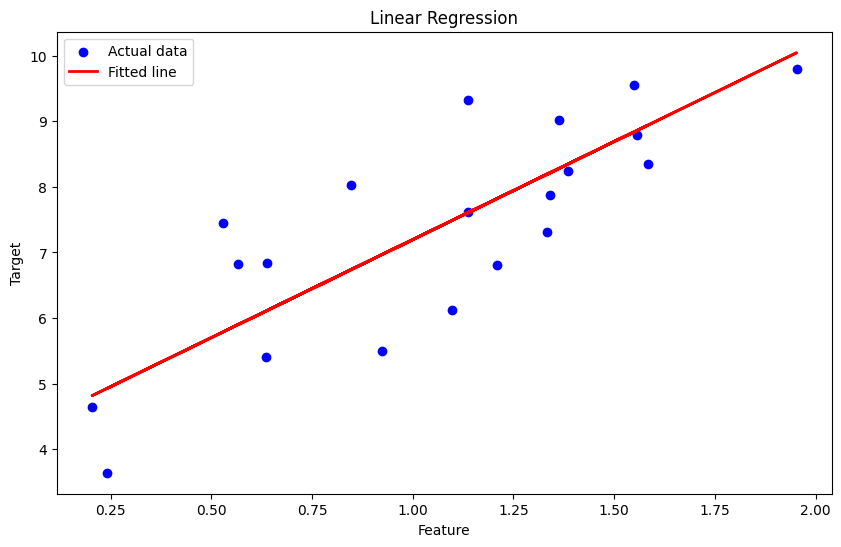

In [62]:

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = model.coef_
intercept = model.intercept_

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print("Coefficients: ", coefficients)
print("Intercept: ", intercept)


# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Fitted line')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.legend()
plt.show()


### **Linear Regression with the Housing Data**

In [65]:
X = df_cal[['median_income']] # notice we need to have a 2d structure - hence [[]]
y = df_cal['median_house_value']

Another way of looking at the first 4 rows...

In [66]:
X[:4]

,median_income
0,1.4936
1,1.8200
2,1.6509
3,3.1917


Mean Squared Error: 6920028496.01
Mean Absolute Error: 62164.20
R^2 Score: 0.50


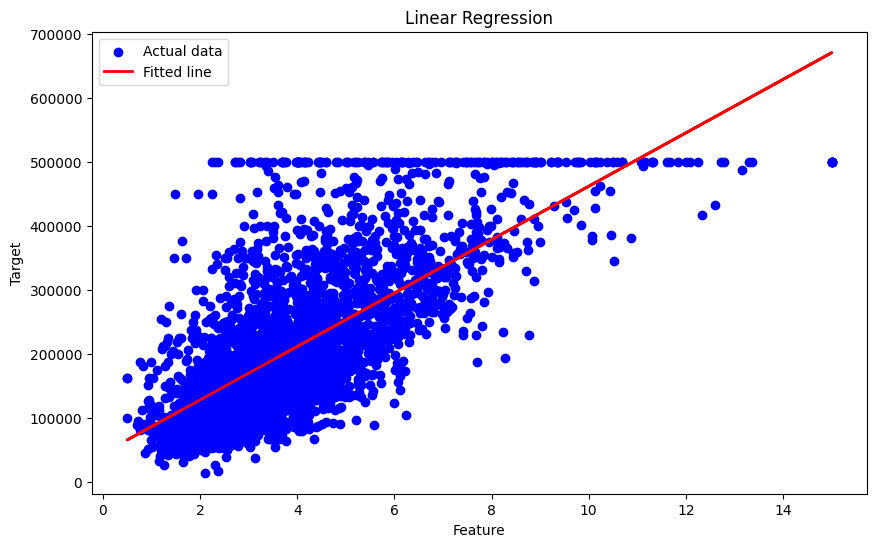

In [67]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
results = model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Fitted line')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [68]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Get model parameters
coefficients = model.coef_
intercept = model.intercept_

# Print summary
print("Model Performance Summary:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Model Performance Summary:
Mean Squared Error (MSE): 6920028496.01
R-squared (R²): 0.50
Mean Absolute Error (MAE): 62164.20
Model Coefficients: [41669.93554652]
Intercept: 45238.28550664187


The limitation is basically not all metrics are readily availailable and you may beed to compute them.  For example, there isnt a easy way to get SE from scikitlearn.  Recall, SE is the estimate in regression analysis measures the average distance that the observed values fall from the predicted values (the regression line). It provides a way to quantify the precision of the predictions made by the regression model  To get it, use something like this:

In [69]:
# Number of observations
n = len(y_test)

# Compute residuals
residuals = np.array(y_test) - np.array(y_pred)

# Compute residual variance
residual_variance = np.var(residuals, ddof=1)  # Use ddof=1 for sample variance or 0 for population

# Calculate Standard Error
standard_error = np.sqrt(residual_variance / n)

print(f'Standard Error: {standard_error}')


Standard Error: 1426.7087808012166


Some more metrics you can find outside of scikitlearn

In [70]:
import scipy.stats as stats

# Calculate the residual variance
residual_variance = np.sum(residuals**2) / (X_test.shape[0] - X_test.shape[1])

# Calculate the variance-covariance matrix
X_transpose_X_inv = np.linalg.inv(np.dot(X_test.T, X_test))
variance_covariance_matrix = residual_variance * X_transpose_X_inv

# Standard errors of coefficients
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# t-statistics
t_stats = model.coef_ / standard_errors

# p-values
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=X_test.shape[0] - X_test.shape[1]))

# Print results
print("Coefficients:", model.coef_)
print("Standard Errors:", standard_errors)
print("t-Statistics:", t_stats)
print("p-Values:", p_values)


Coefficients: [41669.93554652]
Standard Errors: [327.61708577]
t-Statistics: [127.19097189]
p-Values: [0.]


In [71]:
X_test

,median_income
10941,3.5959
5250,8.1124
10292,2.5288
2266,4.2321
6398,1.5326
...,...
4706,2.9688
8404,7.6447
11114,0.9573
7877,5.1377


OLS in StatsModel

In [72]:
X_test['ones'] = 1 # add a column of ones for the intercept term
X_train['ones'] = 1 # add a column of ones for the intercept term


In [73]:
X_test

,median_income,ones
10941,3.5959,1
5250,8.1124,1
10292,2.5288,1
2266,4.2321,1
6398,1.5326,1
...,...,...
4706,2.9688,1
8404,7.6447,1
11114,0.9573,1
7877,5.1377,1


In [74]:
model1 = sm.OLS(y_test, X_test)
results1 = model1.fit()

In [75]:
y_pred1 = results1.predict(X_test)

In [78]:
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     3382.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:09:17   Log-Likelihood:                -43339.
No. Observations:                3400   AIC:                         8.668e+04
Df Residuals:                    3398   BIC:                         8.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
median_income  4.359e+04    749.542     58.158

In [81]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f'RMSE: {rmse}')
mae = mean_absolute_error(y_test, y_pred1)
print(f'MAE: {mae}')

RMSE: 83098.09671032096
MAE: 62154.64959540106
